# COMP90042 Assignment #1: Sentiment analysis for tweets

In [20]:
Student Name: Yun Wang
Student ID: 672323

SyntaxError: invalid syntax (<ipython-input-20-8166fd4864cd>, line 1)

## General info

<b>Due date</b>: 5pm, Mon April 12

<b>Submission method</b>: see LMS

<b>Submission materials</b>: completed copy of this ipython notebook

<b>Late submissions</b>: -10% per day, no late submissions after the first week

<b>Marks</b>: 25% of mark for class

<b>Overview</b>: For this project, you'll be building a 3-way polarity classification system for tweets, using a logistic regression classifier, BOW features, as well as polarity lexicons built from external sources. A key focus of this project is critical analysis and experimental evaluation, for which you will need to report on the relative merits of various options. 

<b>Materials</b>: See the main class LMS page for information on the basic setup required for this class, including an iPython notebook viewer and the python packages NLTK, Numpy, Scipy, Matplotlib, Sci-kit Learn, and Gemsim. In particular, if you are not using a lab computer which already has it installed, we recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python build-in packages, but do not use any other 3rd party packages; if your iPython notebook doesn't run on the marker's machine, you will lose marks. You are encouraged to use the iPython notebooks released for this class as well as other online documentation to guide your responses, but you should not copy directly from any source. The only other data you will need is three sets of tagged tweets, the first two of which (training and dev) were released at the same time as this notebook, and a third set (test) which will be made available about a week before the assignment is due, see Final Testing below. This data comes from the recent SemEval 2016 shared task. Do not distribute this data indiscriminately (i.e. put it on a public website), you should use it only for this assignment, and delete it afterwards. The corpus is comprised of unfiltered text from the web, and may include offensive or objectionable material. This reflects the general composition of the web and the general challenges present in web based text analysis. The University of Melbourne takes no responsibility for opinions expressed in the corpus, nor takes any responsibility for offence caused by these documents.

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time (less than 10 minutes on a lab desktop), and you must follow all instructions provided below, including specific implementation requirements. You will be marked not only on the correctness of your methods, but also on your explanation and analysis. Please do not change any of instruction text in the notebook. Where applicable, leave the output cells in the code, particularly when you are commenting on that output. You should add your answers and code by inserting a markdown cell between every major function or other block of code explaining its purpose or anywhere a result needs to be discussed (see the class notebooks for examples). Note that even if you do something wrong, you might get partial credit if you explain it enough that we can follow your reasoning, whereas a fully correct assignment with no text commentary will not receive a passing score. You will not be marked directly on the performance of your final classifier, but each of the steps you take to build it should be reasonable and well-defended.

<b>Updates</b>: Any major changes to the assignment will be announced via LMS. Minor changes and clarifications will be announced in the forum on LMS, we recommend you check the forum regularly.

<b>Academic Misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this project, and we encourage you to discuss it in general terms with other students. However, it is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.


## Preprocessing

<b>Instructions</b>: Your first task is to carry out preprocessing on the tweets. Use the code below as a starter. Each line of the input files is a json including the tweet and the label (and the tweet id), this code just loads them into a list without any preprocessing. Note that for the labels, 1 = positive, 0 = neutral, -1 = negative. Here is a list of things your preprocessing code must do:

<ul>
<li>Segment into sentences: Use NLTK punkt sentence segmenter</li>
<li>Tokenize sentences: Use the NLTK regex WordPunct tokenizer</li>
<li>Lowercase all words</li>
<li>Remove Twitter usernames: Usernames on twitter begin with @</li>
<li>Remove URLs: URLs start with http</li> 
<li>Remove any hashtags from their original location in the tweet, tokenize them, and add them as a separate sentences with the hash tag removed: for tokenization, use capitalized letters when they occur (e.g. #RefugeesWelcome -> Refugees Welcome), or when there is no capitalization (#refugeeswelcome -> refugees welcome) use the MaxMatch algorithm and the list of English words included in NLTK (nltk.corpus.words.words()). Two notes about the English word list: 1. you should convert it to a python set before you use it (sets are hashed, so you get much quicker lookup) 2. It contains only base forms, so you will need to lemmatize words before you look them up.</li>
</ul>

You can do these in almost any order you like, but it may be useful to do the main segmentation/tokenization last (or almost last), since for the other tasks it is easier to deal with the raw string rather than a list of tokens. The use of regular expressions is recommended, but not required.



In [21]:
import json
import re
import nltk
from nltk.corpus import stopwords


word_set=set(nltk.corpus.words.words())
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
sent_segmenter = nltk.data.load('tokenizers/punkt/english.pickle')
word_tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()
# count the number of tweets required to print
num_tweet_print=1
# a list used to hold the original tweets(in json format)
original_tweet=[]
'''
Preprocess a single tweet.
The method takes a single tweet as input, remove all the '@'s and urls at first, 
then find all the hashtags in this tweet and store them into a list. Then the hashtags 
are tokenized based on whether there is capticalization. If yes, it is splitted using the capital 
letters, if not, it is splitted using maxMatch algorithm-- lemmatize the substring first, then 
look it up in the word_set(nltk.corpus.words.words()). After this, all the hashtags are removed 
from tweet and the tweet is tokenized into sentences then words. Finally, the list of words inside
the hashtag is added to the end of the list of words from tweet and returned.
'''
def preprocess(ori_tweet):
    global num_tweet_print
    # get rid of all the "@"s and urls
    tweet = re.sub("@[^ ]+", "", ori_tweet).strip()
    tweet=re.sub("http[^ ]+","",tweet).strip()
    # Find all the hashtags and put them in a list called hashtag
    hashtag = re.findall('#[^ ]*', tweet)
    tag_list=[]
    if hashtag:
        for tag in hashtag:
            #remove the "#" from one hashtag
            tag=re.sub('#','',tag)
            # if contains capital letters
            if re.search('.*[A-Z].*',tag):
                tag_list=tag_list+re.findall('[A-Z][^A-Z]*',tag)

            else:
                 # if not contain capital letters use a maxmatch algorithm to find the words
                i=0
                while i<len(tag):
                    for j in range(len(tag),i,-1):
                        #lemmatize words first
                        lemma=lemmatize(tag[i:j])
                        if lemma in word_set:
                            tag_list.append(tag[i:j])
                            i=j-1
                    i+=1
    if tag_list:
        for i in range(len(tag_list)):
            tag_list[i]=tag_list[i].lower()
    #remove all the hashtags
    tweet = re.sub('#[^ ]*','',tweet).lower()
    #split tweet into sentences
    tweet = sent_segmenter.tokenize(tweet)
    #put the words in a tweet into a words list
    words = []
    for sentence in tweet:
        words= words+ word_tokenizer.tokenize(sentence)
    #if the tweet has hashtags, add them to the words list too
    if tag_list:
        words=words+tag_list
    if len(tag_list)>1:
        if num_tweet_print<11:
            print num_tweet_print
            print ori_tweet
            print words
            num_tweet_print+=1

    return words

'''
Given the file name, pre-process the file and return a list of preprocessed tweet 
and label lists
'''
def preprocess_file(filename):
    tweets = []
    labels=[]
    f = open(filename)
    for line in f:
        tweet_dict = json.loads(line)
        original_tweet.append(tweet_dict)
        tweets.append(preprocess(tweet_dict["text"]))
        labels.append(int(tweet_dict["label"]))
    return tweets,labels
'''
lemmatize a word. First treat the word as a verb, if not then treat the word as a noun
'''
def lemmatize(word):

    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

<b>Instructions</b>: Once your basic preprocessing module is working, run it on the training set and have it print out 10 examples where your system identified a hashtag with more than one word inside; print out both the original tweet string as well as result after preprocessing. It's okay if you have to duplicate some code from above to do this. Point out any errors you see in the preprocessing, and discuss possible solutions; these can be related to the hashtags, or any other errors you see. You do not have to fix the errors unless they actually indicate a actual bug in your code (at which point you should go back to the previous section, fix the code, and print out the samples again).

In [22]:
trn_tweets,trn_labels=preprocess_file('train.json')

1
If I make a game as a #windows10 Universal App. Will #xboxone owners be able to download and play it in November? @majornelson @Microsoft
[u'if', u'i', u'make', u'a', u'game', u'as', u'a', u'universal', u'app', u'.', u'will', u'owners', u'be', u'able', u'to', u'download', u'and', u'play', u'it', u'in', u'november', u'?', u'windows', u'x', u'box', u'one']
2
@MikeWolf1980 @Microsoft I will be downgrading and let #Windows10 be out for almost the 1st yr b4 trying it again. #Windows10fail
[u'i', u'will', u'be', u'downgrading', u'and', u'let', u'be', u'out', u'for', u'almost', u'the', u'1st', u'yr', u'b4', u'trying', u'it', u'again', u'.', u'windows10', u'windows10fail']
3
For the 1st time @Skype has a "High Startup impact" Does anyone at @Microsoft have a clue?#Windows10Fail http://t.co/loO3yd5rwe
[u'for', u'the', u'1st', u'time', u'has', u'a', u'"', u'high', u'startup', u'impact', u'"', u'does', u'anyone', u'at', u'have', u'a', u'clue', u'?', u'windows10', u'fail']
4
#teens @BillGates 1s

<b>My analysis</b>:
From the above output, we can see the following errors:
1. When the hashtag has several words in it, but does not have enough capital letters to separate them, like  #Windows10fail, our code only split this hashtag based on "W", thus returning Windows10fail as a single word. 
2. When the hashtag is an abbreviation, consisting of only capital letters, like #MBA, which should be recognized as a single word, but our code would split it into "M","B","A"
3. My implementation of maxMatch matches the hashtag from left to right, for hashtags like #casestudy, the algorithm would first match 'cases' with 'case', and 'tudy' is left, no word can be matched with 'tudy'
4. Punctuations are useless most of the times but are not removed.


To solve problem 1 and 2, we have to include a more delicate method to tell if the hashtag is an abbreviation, or if there is not enough capital letters to split the string. In addition, many words are not included in the list of English words from NLTK, thus we may need a more comprehensive lexicon. For error 3, a more intelligent maxMatch algorithm is needed, which will match the longest word in the string first, and is able to tell whether 's' or 'ed' come from the tense of the word. For error 4, we just need to include an extra step to remove punctuations.

<b>Instructions</b>: The next step will be to convert each of your preprocessed tweets into a feature dictionary, that is, a python dictionary where each entry corresponds to a feature and its value. At this stage, you should just build a bag-of-word feature dict, though you must allow for two possible options: one is to remove stopwords (using the NLTK stopword list), and the other is to remove words appearing <em>less</em> than n times across the entire training set (n<=0 should have no effect). The outer function (convert_to_feature dicts) should take the list of tweets resulting from the preprocess_file, and return a list of feature dictionaries in the same order (so they correspond to the label)

In [23]:
'''
Method convert_to_feature_dicts
Take the preprocessed list of tweets as input, remove_stop_words indicates whether to remove
stop words, and n denotes whether to remove words appearing less than n times across the 
entire training set. 
Return a feature dictionary. 

First construct a dictionary using all the words in the training set, which is used to 
identify the words appearing less than n times. These words are stored into small_set. 
If remove_stop_words==True and n >0, then only words not in small_set and stop_word_set 
will be added to the feature dic.
'''

def convert_to_feature_dicts(tweets,remove_stop_words,n):
    feature_dicts = []
    if remove_stop_words:
        stop_word_set=set(stopwords.words('english'))
    if n>0:
        small_set=set()
        whole_feature_dic={}
        for tweet in tweets:
            for w in tweet:
                whole_feature_dic[w]=whole_feature_dic.get(w,0)+1

        for w in whole_feature_dic:
            if whole_feature_dic[w]<=n:
                small_set.add(w)

    for tweet in tweets:
        # build feature dictionary for tweet
        feature_dict={}
        for w in tweet:

            if remove_stop_words and n<=0:
                if w not in stop_word_set:
                    feature_dict[w]=feature_dict.get(w,0)+1
            elif remove_stop_words and n>0:
                if w not in stop_word_set and w not in small_set:
                    feature_dict[w]=feature_dict.get(w,0)+1
            elif n>0:
                if w not in small_set:
                    feature_dict[w]=feature_dict.get(w,0)+1
            else:
                feature_dict[w]=feature_dict.get(w,0)+1

        feature_dicts.append(feature_dict)

    return feature_dicts

## Tuning and classifying

<b>Instructions</b>: Using the functions you've written, you should produce lists of feature dictionaries for both training and development sets; for the training set, remove stopwords and all words that appear only once (do <em>not</em> this for the dev set). Using scikit learn, convert the data to the sparse representation used for training classifiers.

In [24]:

#proprocess training data
trn_tweets,trn_labels=preprocess_file('train.json')
# convert training data into feature dictionaries
trn_feature_dicts=convert_to_feature_dicts(trn_tweets,True,1)
#proprocess development data
dev_tweets,dev_labels=preprocess_file('dev.json')
# convert development data into feature dictionaries
dev_feature_dicts=convert_to_feature_dicts(dev_tweets,True,0)

#convert the data to the sparse representation
from sklearn.feature_extraction import DictVectorizer
def prepare_data(trn_feature_dicts,dev_feature_dicts):
    vectorizer = DictVectorizer()
    trn_feature_dicts = vectorizer.fit_transform(trn_feature_dicts)
    dev_feature_dicts = vectorizer.transform(dev_feature_dicts)
    return trn_feature_dicts,dev_feature_dicts

#convert training data and development data into sparse representation
trn_feature_dicts,dev_feature_dicts=prepare_data(trn_feature_dicts,dev_feature_dicts)

<b>Instructions</b>: Now, tune a decision tree classifier using accuracy in the development set as the evaluation metric. For this, you need to consider at least 2 parameters of the model likely to influence performance and which make sense in this context; you should read the documentation for the classifier on sci-kit learn website to learn what these parameters are. For any binary or categorical parameters, you should just consider all options. For numerical values, you should start by keep other settings on default and just randomly try a wide range, looking for values above which there is a steep drop-off in performance, or, alternatively, no effect on performance at all (you don't need to show this process in the notebook).  Remember that some parameters should be tested on a logarithmic scale. Once you're fairly confident of a good range for the parameter, divide it up into at least 5 steps (but no more than 10), and carry out a grid search, which is to say an exhaustive exploration of all parameter options within the limits you've set (this should be included in the notebook). Identify the best parameter values, and discuss the influence of the parameters on performance in the development set. Do you think some values of the parameters are resulting in overfitting?  

0.458720612356
0.454346637507
0.451612903226
0.446145434664
0.449425915801
0.45106615637
0.437397484964
0.457080371788
0.454893384363
0.43083652269


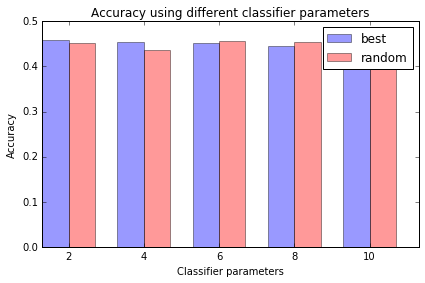

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import numpy as np
'''
test returns the accuracy of the classifier trained on the training data
Input:
clf: the classifier to be used
training_data: the training data
training_classifications: the labels of training data
test_data: the data used to test the accuracy of the classifier trained on training data
test_classifications: the labels of test data
Return: accuracy
'''
def test(clf,training_data,training_classifications,test_data,test_classifications):

    clf.fit(training_data,training_classifications)
    predictions = clf.predict(test_data)
    accuracy = accuracy_score(test_classifications,predictions)
    return accuracy

'''
plot_graph plots the accuracy results of decision tree classifier
Input: 
accuracy_list is used to store the accuracies
range_list indicates the list of numbers of min_samples_split, which is parameter for decision
tree classifier
'''
def plot_graph(accuracy_list,category_list,range_list):
    n_groups = 5
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4
    rects1 = plt.bar(index, accuracy_list[0:5], bar_width,
                     alpha=opacity,
                     color='b',
                     label=category_list[0])
    rects2 = plt.bar(index + bar_width, accuracy_list[5:10], bar_width,
                     alpha=opacity,
                     color='r',
                     label=category_list[1])

    plt.xlabel('Classifier parameters')
    plt.ylabel('Accuracy')
    plt.title('Accuracy using different classifier parameters')
    plt.xticks(index + bar_width, range_list)
    plt.legend()
    plt.tight_layout()
    plt.show()

'''
Train the classifier with different parameter settings. In this assignment,
the parameter splitter(The strategy used to choose the split at each node. 
Supported strategies are “best” to choose the best split and “random” to 
choose the best random split.) and min_samples_split(The minimum number of 
samples required to split an internal node.) are examined. Splitter is set to
'best' and 'random', while min_samples_split is set to 2,4,6,8,10
'''

accuracy_list=[]
for split_method in ['best','random']:
    for num_split in range(2,12,2):
        clf1=DecisionTreeClassifier(splitter=split_method,min_samples_split=num_split)

        acc= test(clf1,trn_feature_dicts,trn_labels,dev_feature_dicts,dev_labels)
        print acc
        accuracy_list.append(acc)
        
plot_graph(accuracy_list,['best','random'],range(2,12,2))

<b>Analysis</b>
From the above graph, we can see that both the parameters I chose do not have much effect on the final prediction accuracy. 

<b>Instructions</b>: Carry out the same tuning process with the logistic regression classifier. Compare the performance of the two classifiers to each other, and to the most common class baseline. How are the classifiers doing? Is this a challenging task?

0.501913613997
0.501366867141
0.501366867141
0.501366867141
0.501366867141
0.506834335703
0.504647348278
0.504647348278
0.504647348278
0.504647348278


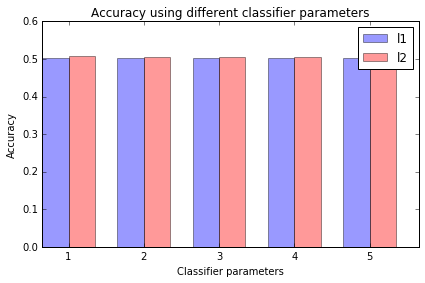

In [26]:
from sklearn.linear_model import LogisticRegression
'''
Build logistic regression model using different parameter settings, i.e. 
max_iter(Maximum number of iterations taken for the solvers to converge)
and penalty(str, ‘l1’ or ‘l2’,Used to specify the norm used in the penalization).
For this assignment, penalty is set to 'l1' and 'l2', while max_iter is set to 10,100,
1000,10000,100000
'''
accuracy_list2=[]
for penalty in ['l1','l2']:
    for max_iter in range(1,6):
        clf2=LogisticRegression(penalty=penalty,max_iter=10**max_iter)
        acc= test(clf2,trn_feature_dicts,trn_labels,dev_feature_dicts,dev_labels)
        print acc
        accuracy_list2.append(acc)
# plot the bar chart
plot_graph(accuracy_list2,['l1','l2'],range(1,6))


<b>Analysis</b> 
From the above graph, the parameters have no influence on the final result at all

<b>Instructions</b>: The next task is a slight detour to test your understanding of the logistic regression classifier: you are going to build your own classifier based on the trained model from sci-kit learn. In particular, you should fill in the MyLogisticRegression class started below which is initialized using the feature weights (coefficients) and constants (intercepts) and list of labels (classes) from the sci-kit learn classifier (see the "Attributes" in the documentation for the Logistic Regression classifier), and which mimics the predict and predict_proba methods from the sci-kit learn classifier object. You should confirm that your solution works by using it in the task at hand: take the classifier defined below, train it on the training data, then create an instance of MyLogisticRegression, and show that your classifier has the same output as the scikit-learn classifier for both predict and predict_proba for 5 samples from the development set. 

In [27]:
''' 
The logistic regression class implemented by myself. 
It uses the calculated coefficents and intercepts to predict the probability 
for different classes, or give the label of the class with highest probability 
score.
'''
class MyLogisticRegression:
    '''
    initialize the class with calculated coefficients, intercepts, and labels of the training 
    data
    '''
    def __init__(self, weights, constants, labels):
        self.weights=weights
        self.constants=constants
        self.labels=labels
    
    '''
    predict_proba takes the training data(which is already converted to a sparse matrix) as input,
    do the calculations and return an array of probabilities, where each row corresponds to the
    probabilities for all the classes for a specific tweet.
    '''
    def predict_proba(self,X):
        prob=[]
        X=X.toarray()
        for index,x in enumerate(X):
            numerator=[]
            i=0
            for weight in self.weights:
                numerator.append(np.exp(np.dot(x, weight)+self.constants[i]))
                i+=1
            denominator=sum(numerator)
            prob.append([])

            for nume in numerator:
                prob[index].append(nume/denominator)
        return np.asarray(prob)
    
    '''
    predict method takes the training data(which is already converted to a sparse matrix) as 
    input and returns the class label with the highest probability.
    '''

    def predict(self,X):
        label_list=[]
        X=X.toarray()
        for index,x in enumerate(X):
            numerator=[]
            i=0
            for weight in self.weights:
                numerator.append(np.exp(np.dot(x, weight)+self.constants[i]))
                i+=1
            denominator=sum(numerator)
            best_prob=-9e99
            best_label=None
            for index2,nume in enumerate(numerator):
                class_prob=nume/denominator
                if class_prob > best_prob:
                    best_prob=class_prob
                    best_label=self.labels[index2]
            label_list.append(best_label)
        return np.asarray(label_list)

# Train a classifier using the training data
clf3 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clf3.fit(trn_feature_dicts,trn_labels)
#Get the classifier built by our own
myLR=MyLogisticRegression(clf3.coef_, clf3.intercept_, clf3.classes_)

#To compare my results with the scikit learn classifier
print myLR.predict(dev_feature_dicts)[0:5]
print clf3.predict(dev_feature_dicts)[0:5]

print myLR.predict_proba(dev_feature_dicts)[0:5]
print clf3.predict_proba(dev_feature_dicts)[0:5]

[ 0  0  1 -1  1]
[ 0  0  1 -1  1]
[[ 0.06249832  0.92153973  0.01596195]
 [ 0.00207452  0.92469591  0.07322956]
 [ 0.38730555  0.18566726  0.42702719]
 [ 0.63109064  0.28846577  0.08044358]
 [ 0.04122416  0.35755894  0.6012169 ]]
[[ 0.06249832  0.92153973  0.01596195]
 [ 0.00207452  0.92469591  0.07322956]
 [ 0.38730555  0.18566726  0.42702719]
 [ 0.63109064  0.28846577  0.08044358]
 [ 0.04122416  0.35755894  0.6012169 ]]


<b>Analysis</b>
From the above result, we can see that the two classifiers give the same result.

## Polarity Lexicons

<b>Instructions</b>: Next we will try integrating information from sources beyond the training set, in the form of polarity lexicons. The main focus of this section is producing and evaluating 3 automatically-built polarity lexicons. The first of these lexicons is SentiWordNet, which is <a href="http://www.nltk.org/howto/sentiwordnet.html"> accessible through NLTK</a>. SentiWordNet has precalculated scores for positive, negative, and neutral sentiment for some of the words in WordNet, but, like WordNet, it is arranged in synsets; building a WSD system to handle this is beyond the scope of this assignment, instead you should take the most common polarity across its senses (neutral if there is a tie). Do this by iterating through all the synsets in WordNet (which may take a little while, the code snippet below has a counter to show your progress), and then create two lists, one of positive words, one of negative words. Show 5 examples of each of the positive and negative words, and comment on their quality.

In [28]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_polarity_type(synset_name):
    swn_synset =  swn.senti_synset(synset_name)
    if not swn_synset:
        return None
    elif swn_synset.pos_score() > swn_synset.neg_score() and swn_synset.pos_score() > swn_synset.obj_score():
        return 1
    elif swn_synset.neg_score() > swn_synset.pos_score() and swn_synset.neg_score() > swn_synset.obj_score():
        return -1
    else:
        return 0
        
positive_list1=[]
negative_list1=[]

#count = 0
for synset in wn.all_synsets():
    #count += 1
    #if count % 1000 == 0:
        #print count
    # count synset polarity for each lemma
    name=synset.name()

    polarity_type=get_polarity_type(name)
    if polarity_type is not None:
        if polarity_type ==1:
            # if the polarity type of the synset name is 1
            # add the lemma to the positive list
            positive_list1+=synset.lemma_names()
        elif polarity_type== -1:
            # if the polarity type of the synset name is -1
            # add the lemma to the negative list
            negative_list1+=synset.lemma_names()

positive_list1=list(set(positive_list1))
negative_list1=list(set(negative_list1))
print '1. positive list negative list'
print positive_list1[0:5],negative_list1[0:5]

1. positive list negative list
[u'gossamer', u'Mighty_Mouse', u'magnetic', u'munificence', u'idealised'] [u'funereal', u'unscientific', u'foul', u'aggression', u'ill_nature']


<b>Analysis</b>
From the above positive list and negative list, we can see that all the words in the positive list can be related to something positive. If they are adjectives, they can be used to discribe something good, or if they are nouns, they are something with good quality or represent a good characteristic of a person. The negative word list is also of good quality, all of the 5 words can be related to something bad.

<b>Instructions</b>: The second lexicon will be built using the word2vec (CBOW) vectors included in NLTK. For this, you will need a small set of positive and negative seed terms, which are given to you below. Calculate cosine similarity between vectors of the seeds terms and each of the words for which you have vectors (if you use Gensim, you can iterate over model.vocab), flip the sign for the negative seeds, and then average to get a score. Use this score to produce a list of positive and negative words; you should include a threshold of ±0.03 for words to be considered positive or negative. Again, show 5 examples of each of the positive and negative words, and comment on their quality.

In [29]:
import gensim
from nltk.data import find

positive_seeds = ["good","nice","excellent","positive","fortunate","correct","superior","great"]
negative_seeds = ["bad","nasty","poor","negative","unfortunate","wrong","inferior","awful"]
'''
second_lexicon takes the positive_seeds and negative_seeds as input, use the sample model from 
'models/word2vec_sample/pruned.word2vec.txt'. For every word in the model.vocab, calculate the 
model similarity of it and the word from positive or negative seed. Flip the sign for negative 
seed and sum them up, then take the average. If the score is more than 0.03, then the word is
added to the positive list, if the score is less than 0.03, then the word is added to the negative
list.
'''
def second_lexicon(positive_seeds,negative_seeds):

    word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
    model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)
    positive_list=[]
    negative_list=[]

    for aword in model.vocab:
        score=0
        for pseed in positive_seeds:
            score+=model.similarity(aword, pseed)
        for nseed in negative_seeds:
            score-=model.similarity(aword,nseed)

        score=score/16.0
        if score>0.03:
            positive_list.append(aword)
        elif score<-0.03:
            negative_list.append(aword)

    return positive_list,negative_list

positive_list2, negative_list2=second_lexicon(positive_seeds, negative_seeds)
print ' 2. positive list negative list'
print positive_list2[0:5], negative_list2[0:5]

ImportError: No module named gensim

<b>Instructions</b>: The third lexicon will be built by calculating PPMI with the seed terms. For this, use the Brown corpus included in NLTK, with co-occurrence defined as <em>binary</em> text co-occurrence (that is, multiple co-occurrences in the same text are not counted); importantly, your solution should <em>not</em> calculate the entire co-occurrence matrix, since you only care about relative co-occurrence with the seeds. As above, average the resulting similarity scores after switching the sign for the negative seeds and use them to produce a list of positive and negative words, and check 5 of each. For PPMI, use a threshold of  ±0.3 for deciding if a word is neutral.

In [31]:
from nltk.corpus import brown
import math
positive_seeds = ["good","nice","excellent","positive","fortunate","correct","superior","great"]
negative_seeds = ["bad","nasty","poor","negative","unfortunate","wrong","inferior","awful"]

'''
get_BOW takes a list of strings as input, return a dictionary with words as keys and the number
of times that word occurs as values.
'''
def get_BOW(text):
    BOW = {}
    for word in text:
        BOW[word.lower()] = BOW.get(word.lower(),0) + 1
    return BOW
'''
third_lexicon takes the positive seeds and negative seeds as input, and returns lists of 
positive words and negative words.
First a dictionary all_dic is created with all the words in brown.words() as entries. Each entry is another
dictionary with positive seeds, negative seeds and 'word_count' as keys. The values of positive
seed keys represent the the co-occurence times of that specific word with the positive seed, and
likewise for negative seeds. The value in 'word_count' represents the number of times that word 
occur throughout the document. Another dicitionary constructed is seed_total_dic, it stores the 
number of times each seed occurs in the document. 
For the co-occurence calculation, multiple co-occurences in the same text is calculated as one.

The 0 and negative PMI scores are discarded, and the signs of PMI scores with negative seeds are 
flipped. The sum is calculated and then divided by 16 to get the average. This figure is then 
compared to +0.3,-0.3 to add words to positive list and negative list. 
'''
def third_lexicon(positive_seeds,negative_seeds):
    positive_list=[]
    negative_list=[]

    all_dic={}
    seed_total_dic={}
    for fileid in brown.fileids():
        bow=get_BOW(brown.words(fileid))
        for aword in bow:
            all_dic[aword]=all_dic.get(aword,{})
            all_dic[aword]['word_count']=all_dic[aword].get('word_count',0)+1
            for pseed in positive_seeds:
                if pseed in bow:
                    all_dic[aword][pseed]=all_dic[aword].get(pseed,0)+1
            for nseed in negative_seeds:
                if nseed in bow:
                    all_dic[aword][nseed]=all_dic[aword].get(nseed,0)+1

        for pseed in positive_seeds:
            if pseed in bow:
                seed_total_dic[pseed]=seed_total_dic.get(pseed,0)+1
        for nseed in negative_seeds:
            if nseed in bow:
                seed_total_dic[nseed]=seed_total_dic.get(nseed,0)+1

    total_count=float(len(brown.fileids()))

    for aword in all_dic:
        score=0
        for pseed in positive_seeds:
            if all_dic[aword].get(pseed) != None:
                a_score=math.log((all_dic[aword][pseed]/total_count)/((all_dic[aword]['word_count']/total_count)*(seed_total_dic[pseed]/total_count)), 2)
                if a_score>0:
                    score+=a_score

        for nseed in negative_seeds:
            if all_dic[aword].get(nseed) != None:
                a_score=math.log((all_dic[aword][nseed]/total_count)/((all_dic[aword]['word_count']/total_count)*(seed_total_dic[nseed]/total_count)), 2)
                if a_score>0:
                    score-=a_score


        score=score/16.0


        if score>0.3:
            positive_list.append(aword)
        elif score<-0.3:
            negative_list.append(aword)

    return positive_list,negative_list

positive_list3, negative_list3=third_lexicon(positive_seeds, negative_seeds)
print '3. positive list negative list'
print positive_list3[0:5], negative_list3[0:5]

3. positive list negative list
[u'francesca', u'comically', u'spidery', u'ultra-violet', u'non-violent'] [u'bilharziasis', u'pigment', u'wooden', u'deferments', u'blot-appearance']


<b>Analysis</b>
The resulted list does not seem to be of good quality. Francesca is a name and ultra-violet is an object, they both should be neutral rather than positive. Comically and spidery are more likely to be neutral words as well. As for the negative list, pigment and wooden do not seem negative. 
This is mainly due to the fact that the PPMI scores are calculated on a text level instead of a sentence level. The words in the same text are less correlated to each other than the words in the same sentence, thus resulting in a list of bad quality.

<b>Instructions</b>: Now you will test these automatically-produced lexicons against a manually-annotated set. There is a manually-built lexicon (the Hu and Liu lexicon) which is included with NLTK. It has a list of positive and negative words, which are accessed as below. First, investigate what percentage of the words in the manual lexicon are in each of the automatic lexicons, and then, only for those words which overlap and which are <em>not</em> in the seed set, evaluate the accuracy of with each of the automatic lexicons. Discuss the results, mentioning why you think the lexicon which won out did.

In [32]:
from nltk.corpus import opinion_lexicon
'''
calculate_percentage takes two lists as input, return the percentage of the overlapping words
in the first list.
'''
def calculate_percentage(manual,automatic):
    #automatic=set(automatic)
    count=0
    for word in manual:
        if word in automatic:
            count+=1
    return float(count)/len(manual)


positive_words = opinion_lexicon.positive()
negative_words = opinion_lexicon.negative()

print 'lexicon 1 positive:',calculate_percentage(positive_words,positive_list1)
print 'lexicon 1 negative:',calculate_percentage(negative_words,negative_list1)
'''
print 'lexicon 2 positive:',calculate_percentage(positive_words, positive_list2)
print 'lexicon 2 negative:',calculate_percentage(negative_words, negative_list2)
'''
print 'lexicon 3 positive:',calculate_percentage(positive_words, positive_list3)
print 'lexicon 3 negative:',calculate_percentage(negative_words, negative_list3)

lexicon 1 positive: 0.272183449651
lexicon 1 negative: 0.288939995819
lexicon 3 positive: 0.0438683948156
lexicon 3 negative: 0.0449508676563


<b>Instructions</b>: Now you will use the lexicons (both manual and automatic) for the main classification problem. Create a function which calculates a polarity score for a sentence based on a given lexicon (i.e. counting positive and negative words that appear in the tweet, and then returning +1 if there are more positive words, -1 if there are more negative words, and 0 otherwise). Then, use this to compare the results of the different lexicons (please convert them to sets!) on the task in the development set, i.e. the accuracy relative to the human-annotated labels. Do the results reflect the quality of the lexicon as indicated by the earlier analysis? How does it compare to the logistic regression classifier?

In [33]:
'''
my_polarity takes a list and two sets as input, the list represents a single tweet and pset is 
positive word set and nset the negative word set. If there are more words in pset, return 1. If
there are more words in nset, return -1.
'''
def my_polarity(tweet,pset,nset,):
    score=0
    for word in tweet:
        if word in pset:
            score+=1
        elif word in nset:
            score-=1
    if score>0:
        return 1
    elif score<0:
        return -1
    else:
        return 0
'''
accuracy_of_lexicon takes a tweets list, a labels list and a positive list, a negative list. It 
calculates the accuracy of the input lexicon.
'''
def accuracy_of_lexicon(tweets,labels,plist,nlist):
    count=0
    pset=set(plist)
    nset=set(nlist)

    for tweet,label in zip(tweets,labels):
        if label==my_polarity(tweet,pset,nset):
            count+=1

    return float(count)/len(labels)

print 'accuracy of lexicon'
print 'Hu and Liu lexicon:',accuracy_of_lexicon(dev_tweets,dev_labels,positive_words,negative_words)
print 'lexicon 1:',accuracy_of_lexicon(dev_tweets,dev_labels,positive_list1,negative_list1)
#print 'lexicon 2:',accuracy_of_lexicon(dev_tweets,dev_labels,positive_list2,negative_list2)
print 'lexicon 3:',accuracy_of_lexicon(dev_tweets,dev_labels,positive_list3,negative_list3)

accuracy of lexicon
Hu and Liu lexicon: 0.453799890651
lexicon 1: 0.41498086386
lexicon 3: 0.363039912521


<b>Instructions</b>: Now you should investigate the effect of adding the polarity score (or scores) as a feature in your statistical classifier. You should create a new version of your convert_to_feature_dict function (with a different name) to include the extra feature (or features), do not modify the code in that earlier section directly. Retrain your best logistic regression classifier from the early tuning, test on the development set. Comment on the results.

## Error analysis and improvement

<b>Instructions</b>: Using your best logistic regression classifier so far, first write a function to identify errors your classifier is making where the probability of the predicted class and the actual class are fairly close (less than 0.2); you're looking for cases which you have a good chance of getting right with a small improvement. For this, do an 80/20 split of  the training dataset (that is, train on 80% of the data, test on 20%); do not look at examples from the development set or the test set. You should print out the tweet, the correct class, the predicted class, and the probabilities. Don't print all the errors, just use random.sample to select 30 from the full set. Look for general patterns in the errors, and propose a reasonable improvement to your classifier that you think might help with a problem that you are seeing. It could involve, for instance, better preprocessing, the addition of new features, some kind of feature selection, better lexicons or better use of the lexicons, or even a post-processing step. It should not require additional data, unless it involves a small set of words that you can hardcode.

In [34]:
# get the classifier with best performance
clf_err= LogisticRegression()

'''
get_err_list takes the trn_feature_dicts(a sparse matrix), trn_labels, and clf_err(a logistic
regression classifier) as input, and returns a list of mis-predicted tweets,its actual label, 
predicted label, the probability for its actual label, and the probability for its predicted 
label.

The classifier is trained on 4/5 of the training data, and tested on the rest 1/5 data.
'''
def get_err_list(trn_feature_dicts,trn_labels,clf_err):
    len_trn=trn_feature_dicts.shape[0]
    clf_err.fit(trn_feature_dicts.toarray()[0:len_trn*4/5],trn_labels[0:len_trn*4/5])
    predictions=clf_err.predict(trn_feature_dicts[len_trn*4/5:len_trn])
    prediction_probs=clf_err.predict_proba(trn_feature_dicts[len_trn*4/5:len_trn])
    i=0
    err_list=[]
    # pre is predicted label, label is the actual correct label
    for pre,label in zip(predictions,trn_labels[len_trn*4/5:len_trn]):
        if pre!=label:
            probs = prediction_probs[i]
            # the probability for the predicted label and the probability for the actual label
            predict_prob=0
            actual_prob=0
            for index,class_label in enumerate(clf_err.classes_):
                if class_label==label:
                    actual_prob=probs[index]
                elif class_label==pre:
                    predict_prob=probs[index]
            # If the two probabilities are fairly close

            if predict_prob-actual_prob<0.2:
                err_list.append([original_tweet[len_trn*4/5+i],label,pre,actual_prob,predict_prob])              
        i+=1
    return err_list

err_list=get_err_list(trn_feature_dicts,trn_labels,clf_err)
random_index=np.random.randint(len(err_list), size=30)
for an_index in random_index:
    print err_list[an_index][0]
    print err_list[an_index][1:5]

{u'text': u"Feel sorry for anyone going to the Justin Beiber concert tomorrow, they're missing out on one of the best games of the night", u'id': u'900927715', u'label': -1}
[-1, 0, 0.3465201093080395, 0.45564566602955964]
{u'text': u'OK SORRY SM Sta. Rosa, November 10! See you guys! =)', u'id': u'36909155', u'label': 1}
[1, 0, 0.46021443655187311, 0.52350488517115523]
{u'text': u'@Diana_Gomez90 Text me tomorrow if you get a chance! I watched TVD tonight', u'id': u'69449995', u'label': 0}
[0, 1, 0.44989738399991602, 0.48471868115458638]
{u'text': u"lmao my last retweet, I was popped from 6th grade to sophomore year, Jr year I was doing something, and Sr year, you couldn't tell me shit", u'id': u'231316097', u'label': 0}
[0, 1, 0.32506130123989824, 0.38661421371182625]
{u'text': u"My dads all buying beds for the house in Wisconsin . Like bitch I haven't been there since 6th grade", u'id': u'333651366', u'label': -1}
[-1, 0, 0.39096563979416354, 0.50480352870853518]
{u'text': u'I rate Le

<b>Instructions</b>: Now implement that improvement, and then investigate its effect <em>in the development data</em>. Obviously, different improvements may involve different amounts of effort; if your improvement is fairly simple, we expect that you will do a more in-depth analysis, testing possible variations. You can also do multiple related improvements. Students who put extra effort into this may get few extra points that can offset any mistakes on other parts of the assignment, though we do not recommend you spend extra time on this before the other parts of the assignment are complete.

## Final testing and discussion

<b>Instructions</b>: When the final test set has been released, you should start with your best classifier from your work up to this point, and do a final test of all major options, including at least one from each of the first four sections of the assignment (that is, at least one preprocessing option, at least one tuning parameter/classifier type, at least one lexicon, and your improvement), in this new dataset. You don't need to explore every possible combination (in fact, you shouldn't), but you should make a convincing case that you have probably found the best combination given the possibilities you have implemented. It's okay if you find discrepancies between the best classifier on the test set and development set, just be sure to mention them. In a final discussion (which should be at least 500 words), you should include at least one bar graph of accuracy across various options, and at least one table which reports precision, recall, and F-score for each label as well as the macroaveraged F-score (all figures and tables should be generated inline by your code, using matplotlib). Please conclude your discussion by discussing what you have learned, and mentioning any other ideas for improving performance of this system that you may have.

Note that you may have to direct matplotlib to display the figures inline, as shown below.

In [30]:
%matplotlib inline